# Probability, efficiency and $\Delta$R

In this NB I plot:
- Distribution of assignment probabilities from the output h5 file
- Same for detection probabilities
- Leptonic top invariant mass (with inclusion of lepton reco and met)
- H pt vs t1 efficiency
- Differences in pt of predicted jet vs true jet
- Delta R of predicted jet and true jet

In [2]:
import h5py
import awkward as ak
import vector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
from matplotlib.colors import LogNorm
hep.style.use(hep.style.ROOT)
mpl.rcParams['figure.dpi'] = 50
vector.register_awkward()
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
mpl.rcParams['grid.alpha'] = 0.2
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 26
mpl.rcParams['lines.linewidth'] = 2.5

In [3]:
df = h5py.File('./SPANet/predictions/0405_output_v49_matched.h5','r')
df_input = h5py.File('./SPANet/data/tth_matched_3.h5','r')
#fields = ['pt','eta','phi','btag']
#jets = ak.zip({
#    f: df["INPUTS"]["Source"][f][()] for f in fields
#}, with_name="Momentum4D")
#jets["m"] = np.zeros_like(jets.pt)
#jets[0].tolist()

In [4]:
df_jets = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df_jets)
jets = ak.with_name(jets, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

# Get fully matched jets from df_jets
mask_fullymatched = ak.sum(jets.matched == True, axis=1)>=6
jets = jets[mask_fullymatched]
higgs = jets[jets.prov == 1]
mask_match = ak.num(higgs) == 2

w_or_t_jets = jets[(jets.prov == 5)|(jets.prov == 2)]
mask_match = mask_match & (ak.num(w_or_t_jets) == 3)

lep_top = jets[jets.prov == 3]
mask_match = mask_match & (ak.num(lep_top) == 1)

jets = jets[mask_match]

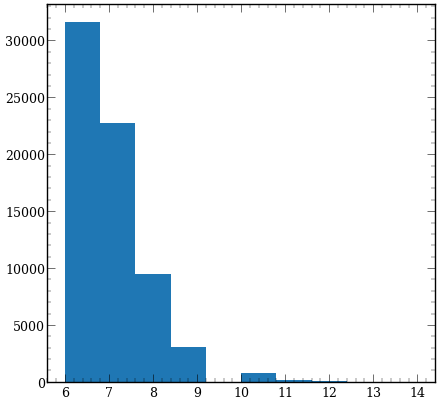

In [28]:
plt.hist(ak.num(jets));

## Assignment probabilities

Plot distribution of assignment probabilities for ttH

In [29]:
h_assign = df["TARGETS/h/assignment_probability"]
t1_assign = df["TARGETS/t1/assignment_probability"]
t2_assign = df["TARGETS/t2/assignment_probability"]

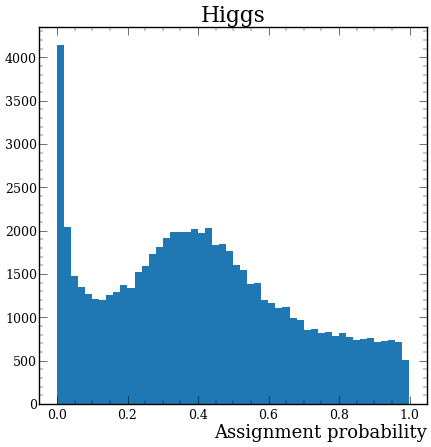

In [30]:
plt.hist(h_assign, bins=50)
plt.title("Higgs")
plt.xlabel("Assignment probability")
plt.show()

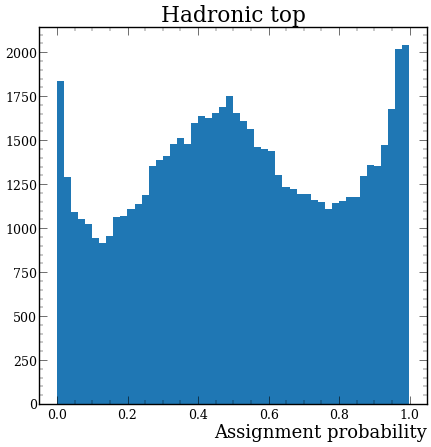

In [31]:
plt.hist(t1_assign, bins=50)
plt.title("Hadronic top")
plt.xlabel("Assignment probability")
plt.show()

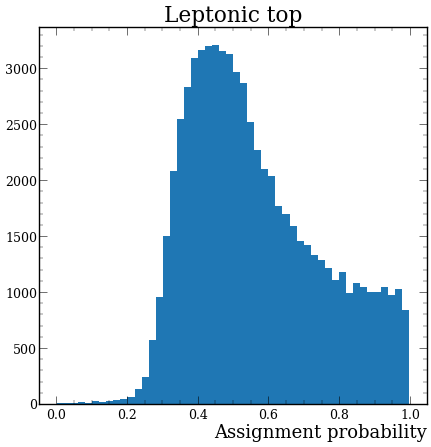

In [32]:
plt.hist(t2_assign, bins=50)
plt.title("Leptonic top")
plt.xlabel("Assignment probability")
plt.show()

## Detection probabilities

In [33]:
h_detect = df["TARGETS/h/detection_probability"]
t1_detect = df["TARGETS/t1/detection_probability"]
t2_detect = df["TARGETS/t2/detection_probability"]

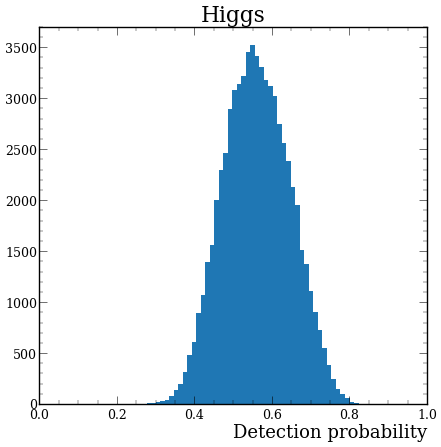

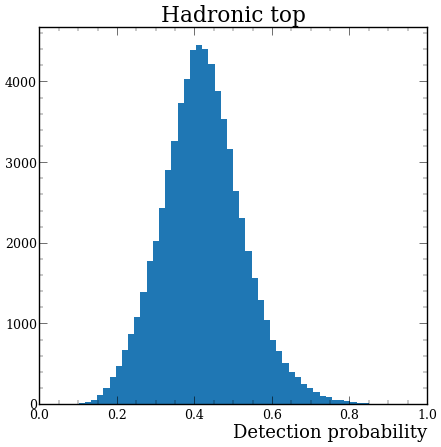

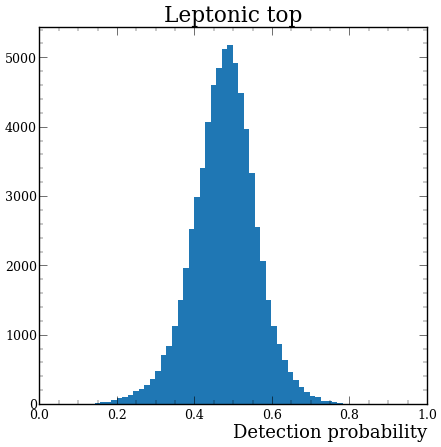

In [34]:
plt.hist(h_detect, bins=50)
plt.title("Higgs")
plt.xlabel("Detection probability")
plt.xlim(0,1)
plt.show()

plt.hist(t1_detect, bins=50)
plt.title("Hadronic top")
plt.xlabel("Detection probability")
plt.xlim(0,1)
plt.show()

plt.hist(t2_detect, bins=50)
plt.title("Leptonic top")
plt.xlabel("Detection probability")
plt.xlim(0,1)
plt.show()

## Leptonic top invariant mass

Reconstruct leptonic top with leptonic information

In [35]:
lepton_reco = lepton_reco[mask_match]
met = met[mask_match]

In [36]:
# Leptonic top jets
t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))

leptop_index_pred = t2_b_pred
leptop_index_true = t2_b_true

leptop_jet_pred = jets[leptop_index_pred]
leptop_jet_true = jets[leptop_index_true]

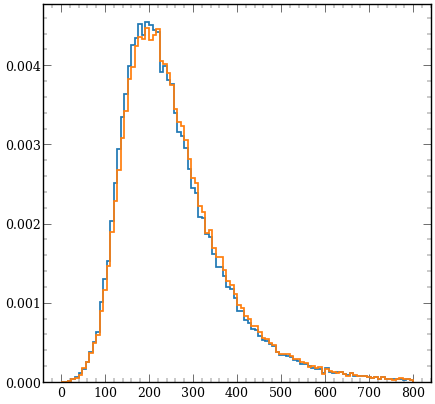

In [39]:
plt.hist((lepton_reco[:] + met[:] + leptop_jet_true[:,0]).m, bins=100,
         density=True, histtype="step", label="true", range=(0,800), linewidth=2.5)
plt.hist((lepton_reco[:] + met[:] + leptop_jet_pred[:,0]).m, bins=100,
         density=True, histtype="step", label="predicted", range=(0,800), linewidth=2.5)
#plt.xlabel(r"$m_{l\nu b}$")
#plt.title("Leptonic top")
#plt.legend()
#plt.show()
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig("./efficiency_plots/t2_m.png", transparent=False, dpi=300,
            bbox_inches='tight')

## 2D efficiency (H and t1)

Efficiency plot in 2D with Higgs pt and t1 pt. When t1 has low pt, is H efficiency high etc...

In [5]:
def get_leptop_arrays(n, njets, mode="partial"):

    # Leptonic top jets
    t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
    t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

    t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
    t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))
    
    leptop_index_pred = t2_b_pred
    leptop_index_true = t2_b_true
    
    if mode == "partial":
        leptop_index_pred = leptop_index_pred[ak.num(jets)==n]
        leptop_index_true = leptop_index_true[ak.num(jets)==n]

    leptop_jet_pred = njets[leptop_index_pred]
    leptop_jet_true = njets[leptop_index_true]

    mask = (leptop_jet_true == leptop_jet_pred)
    leptop_pred_correct = leptop_jet_pred[mask] # correctly predicted jets
    leptop_pred_wrong = leptop_jet_pred[~mask] # wrongly predicted jets

    leptop_pred_correct = leptop_pred_correct[ak.num(leptop_pred_correct)>0]
    leptop_pred_wrong = leptop_pred_wrong[ak.num(leptop_pred_wrong)>0]

    return leptop_pred_correct, leptop_pred_wrong

def get_higgs_arrays(n, njets, mode="partial"):
    
    H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
    H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

    H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
    H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

    H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
    H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])
    
    H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
    H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))
 
    higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
    higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)
    
    if mode == "partial":
        higgs_index_true = higgs_index_true[ak.num(jets)==n]
        higgs_index_pred = higgs_index_pred[ak.num(jets)==n]

    higgs_jet_true = njets[higgs_index_true]
    higgs_jet_pred = njets[higgs_index_pred]
        
    mask = (higgs_jet_true == higgs_jet_pred)
    higgs_pred_correct = higgs_jet_pred[mask] # correctly predicted jets
    higgs_pred_wrong = higgs_jet_pred[~mask] # wrongly predicted jets

    higgs_pred_correct = higgs_pred_correct[ak.num(higgs_pred_correct)==2]
    higgs_pred_wrong = higgs_pred_wrong[ak.num(higgs_pred_wrong)>0]

    return higgs_pred_correct, higgs_pred_wrong

def get_hadtop_arrays(n, njets, mode="partial"):
    
    t1_q1_true = ak.Array(df_input["TARGETS"]["t1"]["q1"][()])
    t1_q2_true = ak.Array(df_input["TARGETS"]["t1"]["q2"][()])
    t1_b_true = ak.Array(df_input["TARGETS"]["t1"]["b"][()])

    t1_q1_true = ak.unflatten(t1_q1_true, ak.ones_like(t1_q1_true))
    t1_q2_true = ak.unflatten(t1_q2_true, ak.ones_like(t1_q2_true))
    t1_b_true = ak.unflatten(t1_b_true, ak.ones_like(t1_b_true))
    
    t1_q1_pred = ak.Array(df["TARGETS"]["t1"]["q1"][()])
    t1_q2_pred = ak.Array(df["TARGETS"]["t1"]["q2"][()])
    t1_b_pred = ak.Array(df["TARGETS"]["t1"]["b"][()])
    
    t1_q1_pred = ak.unflatten(t1_q1_pred, ak.ones_like(t1_q1_pred))
    t1_q2_pred = ak.unflatten(t1_q2_pred, ak.ones_like(t1_q2_pred))
    t1_b_pred = ak.unflatten(t1_b_pred, ak.ones_like(t1_b_pred))
 
    hadtop_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
    hadtop_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)
    
    if mode == "partial":
        hadtop_index_true = hadtop_index_true[ak.num(jets)==n]
        hadtop_index_pred = hadtop_index_pred[ak.num(jets)==n]

    hadtop_jet_true = njets[hadtop_index_true]
    hadtop_jet_pred = njets[hadtop_index_pred]
        
    mask = (hadtop_jet_true == hadtop_jet_pred)
    hadtop_pred_correct = hadtop_jet_pred[mask] # correctly predicted jets
    hadtop_pred_wrong = hadtop_jet_pred[~mask] # wrongly predicted jets

    hadtop_pred_correct = hadtop_pred_correct[ak.num(hadtop_pred_correct)==3]
    hadtop_pred_wrong = hadtop_pred_wrong[ak.num(hadtop_pred_wrong)>0]

    return hadtop_pred_correct, hadtop_pred_wrong

def calculate_efficiency(particle, n, njets, mode="partial"):
    if particle == "h":
        pred_correct, pred_wrong = get_higgs_arrays(n, njets, mode)
    if particle == "t1":
        pred_correct, pred_wrong = get_hadtop_arrays(n, njets, mode)
    if particle == "t2":
        pred_correct, pred_wrong = get_leptop_arrays(n, njets, mode)
    print(f"\nNumber of correctly predicted within {n} jets is {len(pred_correct)}")
    print(f"Number of wrongly predicted within {n} jets is {len(pred_wrong)}")
    print(f"Total within {n} jets is {len(njets)}")
    
    purity = len(pred_correct)/len(njets)
    print(f"{n}-jet efficiency is {purity:.3f}")
    
    return pred_correct, pred_wrong

In [6]:
def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1

def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [7]:
def pt_efficiency(true_pt, pred_pt, nbins, binwidth):
    
    # Bin the array of predicted pts
    data = pd.DataFrame({"pt": pred_pt})

    bins = create_bins(lower_bound=0, width=binwidth, quantity=nbins)
    bin_means = []
    for i in range(len(bins)):
        bin_means.append((bins[i][0] + bins[i][1])/2)

    bins = pd.IntervalIndex.from_tuples(bins)
    data['pt_bin'] = pd.cut(data['pt'], bins=bins)
    
    # Find all counts (correctly and wrongly predicted -- denominator of efficiency)
    a = data['pt_bin'].value_counts(sort=False)
    a.index = a.index.astype(str)
    a = a.to_dict()
    all_counts = np.array(list(a.values()))
    
    # Construct correctly predicted and wrongly predicted jet pts
    mask = (true_pt == pred_pt)

    # Find counts of correctly predicted events
    data['correct'] = mask
    data = data[data['correct']==True]
    c = data['pt_bin'].value_counts(sort=False)
    c.index = c.index.astype(str)
    c = c.to_dict()
    correct_counts = np.array(list(c.values()))

    # Find the efficiency for each interval
    bin_efficiency = np.zeros(len(correct_counts))

    for i in range(len(all_counts)):
        if all_counts[i] > 0: # disregard empty bins and assign 0 efficiency to them
            bin_efficiency[i] = correct_counts[i]/all_counts[i]
        else:
            bin_efficiency[i] = 0
            
    return bin_means, bin_efficiency

In [8]:
H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])

H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))

higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)

higgs_jet_true = jets[higgs_index_true]
higgs_jet_pred = jets[higgs_index_pred]

higgs_true_pt = (higgs_jet_true[:,0] + higgs_jet_true[:,1]).pt
higgs_pred_pt = (higgs_jet_pred[:,0] + higgs_jet_pred[:,1]).pt

t1_q1_true = ak.Array(df_input["TARGETS"]["t1"]["q1"][()])
t1_q2_true = ak.Array(df_input["TARGETS"]["t1"]["q2"][()])
t1_b_true = ak.Array(df_input["TARGETS"]["t1"]["b"][()])

t1_q1_true = ak.unflatten(t1_q1_true, ak.ones_like(t1_q1_true))
t1_q2_true = ak.unflatten(t1_q2_true, ak.ones_like(t1_q2_true))
t1_b_true = ak.unflatten(t1_b_true, ak.ones_like(t1_b_true))

t1_q1_pred = ak.Array(df["TARGETS"]["t1"]["q1"][()])
t1_q2_pred = ak.Array(df["TARGETS"]["t1"]["q2"][()])
t1_b_pred = ak.Array(df["TARGETS"]["t1"]["b"][()])

t1_q1_pred = ak.unflatten(t1_q1_pred, ak.ones_like(t1_q1_pred))
t1_q2_pred = ak.unflatten(t1_q2_pred, ak.ones_like(t1_q2_pred))
t1_b_pred = ak.unflatten(t1_b_pred, ak.ones_like(t1_b_pred))

hadtop_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
hadtop_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)

hadtop_jet_true = jets[hadtop_index_true]
hadtop_jet_pred = jets[hadtop_index_pred]

hadtop_true_pt = (hadtop_jet_true[:,0] + hadtop_jet_true[:,1] + hadtop_jet_true[:,2]).pt
hadtop_pred_pt = (hadtop_jet_pred[:,0] + hadtop_jet_pred[:,1] + hadtop_jet_pred[:,2]).pt

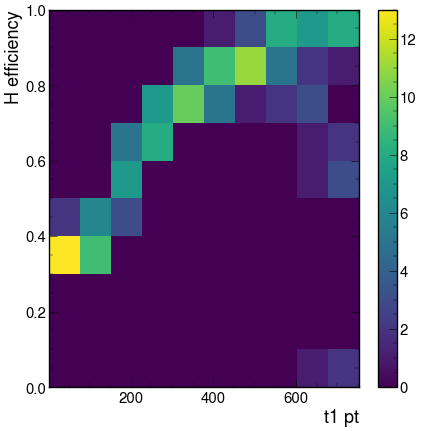

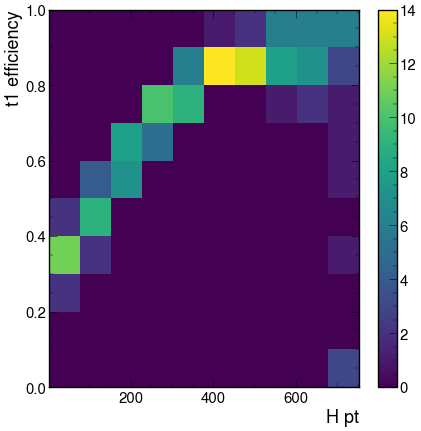

In [88]:
h_means, h_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt,
                                      nbins=150, binwidth=5)
t1_means, t1_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt,
                                        nbins=150, binwidth=5)

plt.hist2d(t1_means, h_efficiency)
plt.xlabel("t1 pt")
plt.ylabel("H efficiency")
plt.colorbar()
plt.show()

plt.hist2d(h_means, t1_efficiency)
plt.xlabel("H pt")
plt.ylabel("t1 efficiency")
plt.colorbar()
plt.show()

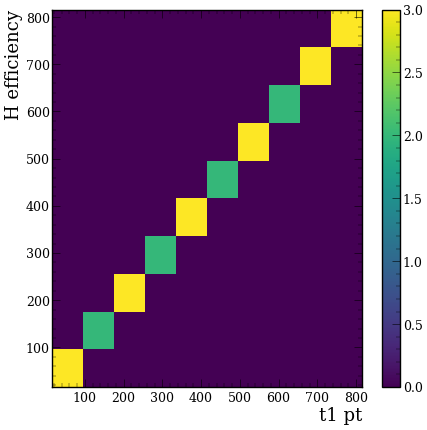

In [50]:
h_means, h_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt,
                                      nbins=25, binwidth=32)
t1_means, t1_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt,
                                        nbins=25, binwidth=32)

plt.hist2d(t1_means, h_means)
plt.xlabel("t1 pt")
plt.ylabel("H efficiency")
plt.colorbar()
plt.show()

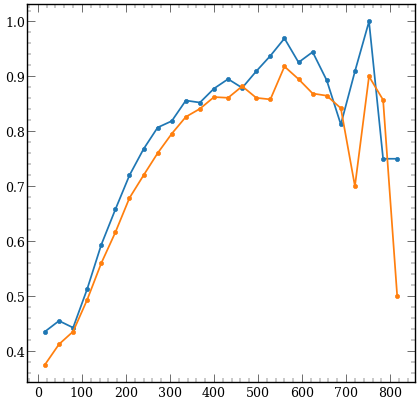

In [51]:
plt.plot(h_means, h_efficiency, marker='o')
plt.plot(t1_means, t1_efficiency, marker='o');

## Difference in pt 

How far apart in pt are the correct jet and the predicted jet (for each particle). In these plots I exclude the correct predictions.

Average pt difference: 61.317
Median pt difference: 46.101
Maximum pt difference: 734.528
Minimum pt difference: 0.002


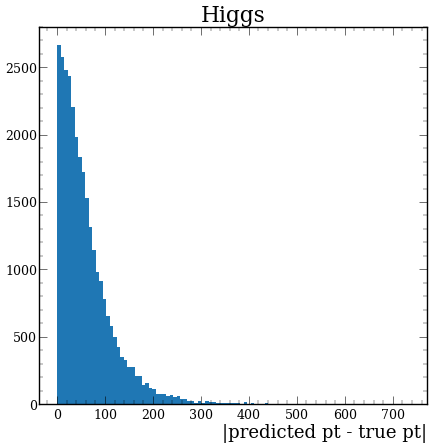

In [52]:
difference = abs(higgs_true_pt - higgs_pred_pt)
# Exclude correct predictions, i.e. zero differences
difference = difference[difference > 0.]
print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference):.3f}")
plt.hist(difference, bins=100)
plt.xlabel("|predicted pt - true pt|")
plt.title("Higgs")
plt.show()

Average pt difference: 17.622
Median pt difference: 16.227
Maximum pt difference: 716.576
Minimum pt difference: -734.528


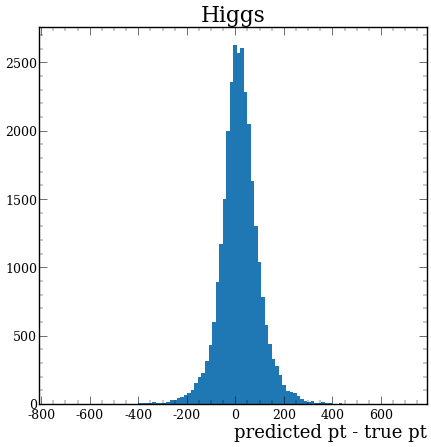

In [53]:
difference = higgs_true_pt - higgs_pred_pt
# Exclude correct predictions, i.e. zero differences
difference = difference[difference != 0.]
print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference):.3f}")
plt.hist(difference, bins=100)
plt.xlabel("predicted pt - true pt")
plt.title("Higgs")
plt.show()

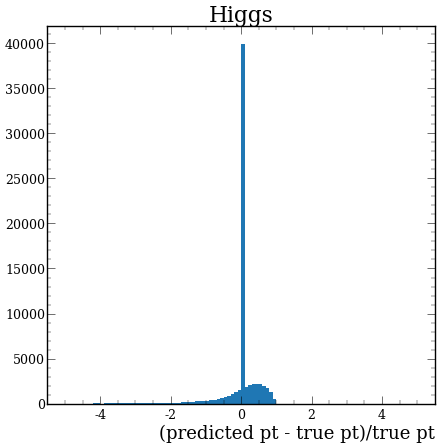

rms: 55.588
Average pt difference: 17.622
Median pt difference: 16.227
Maximum pt difference: 716.576
Minimum pt difference: -734.528


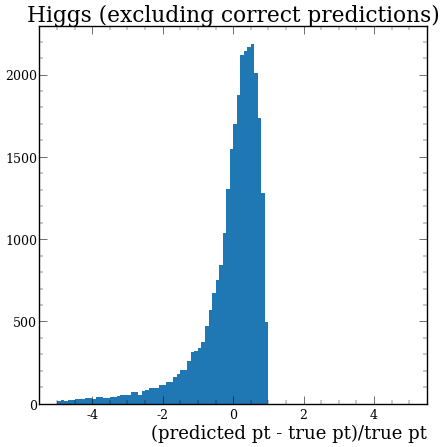

In [54]:
# rms of delta pt over pt
difference = higgs_true_pt - higgs_pred_pt
# Exclude correct predictions, i.e. zero differences
#true_pt = higgs_true_pt[difference != 0.]
#difference = difference[difference != 0.]

rms_difference = np.sqrt(np.sum(difference**2)/len(difference))

plt.hist(difference/higgs_true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Higgs")
plt.show()

print(f"rms: {rms_difference:.3f}")
true_pt = higgs_true_pt[difference != 0.]
difference = difference[difference != 0.]

print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference):.3f}")

plt.hist(difference/true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Higgs (excluding correct predictions)")
plt.show()

Average pt difference: 60.427
Median pt difference: 43.571
Maximum pt difference: 672.546
Minimum pt difference: 9.5367431640625e-07


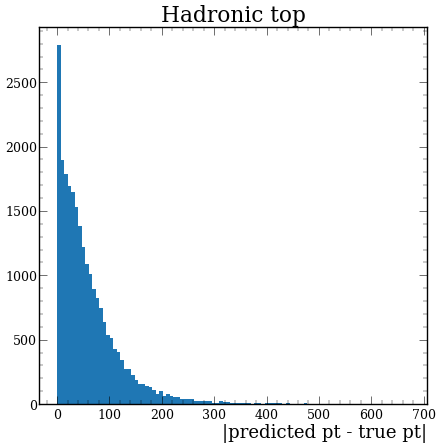

In [55]:
difference = abs(hadtop_true_pt - hadtop_pred_pt)
# Exclude correct predictions, i.e. zero differences
difference = difference[difference > 0.]

print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference)}")
plt.hist(difference, bins=100)
plt.xlabel("|predicted pt - true pt|")
plt.title("Hadronic top")
plt.show()

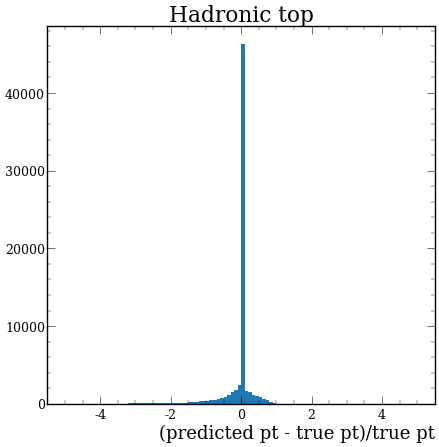

rms: 51.138
Average pt difference: -16.666
Median pt difference: -10.927
Maximum pt difference: 591.788
Minimum pt difference: -672.545654296875


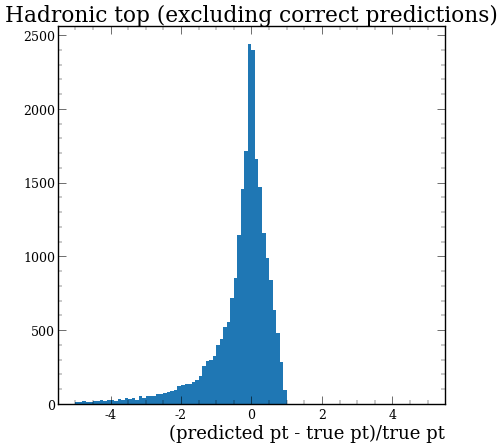

In [56]:
difference = hadtop_true_pt - hadtop_pred_pt
# Exclude correct predictions, i.e. zero differences
#difference = difference[difference != 0.]

rms_difference = np.sqrt(np.sum(difference**2)/len(difference))

plt.hist(difference/hadtop_true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Hadronic top")
plt.show()

print(f"rms: {rms_difference:.3f}")
true_pt = hadtop_true_pt[difference != 0.]
difference = difference[difference != 0.]

print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference)}")

plt.hist(difference/true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Hadronic top (excluding correct predictions)")
plt.show()

In [57]:
# Leptonic top jets
t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))

leptop_index_pred = t2_b_pred
leptop_index_true = t2_b_true

leptop_jet_pred = jets[leptop_index_pred]
leptop_jet_true = jets[leptop_index_true]

leptop_pred_pt = leptop_jet_pred[:,0].pt
leptop_true_pt = leptop_jet_true[:,0].pt

Average pt difference: 42.594
Median pt difference: 29.938
Maximum pt difference: 601.625
Minimum pt difference: 0.016


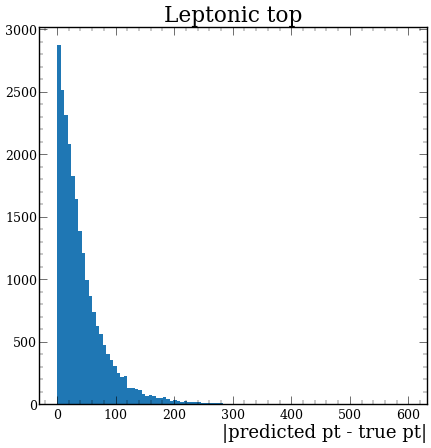

In [58]:
difference = abs(leptop_true_pt - leptop_pred_pt)
# Exclude correct predictions, i.e. zero differences
difference = difference[difference > 0.]

print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference):.3f}")
plt.hist(difference, bins=100)
plt.xlabel("|predicted pt - true pt|")
plt.title("Leptonic top")
plt.show()

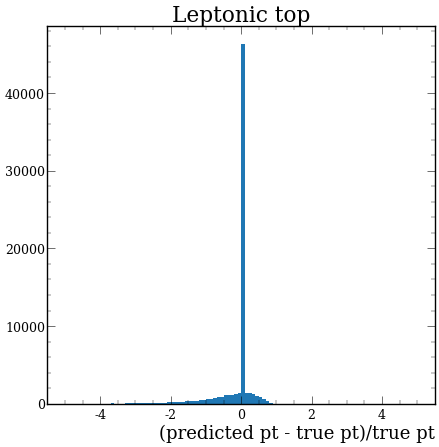

rms: 35.615
Average pt difference: -15.192
Median pt difference: -13.688
Maximum pt difference: 601.625
Minimum pt difference: -501.625


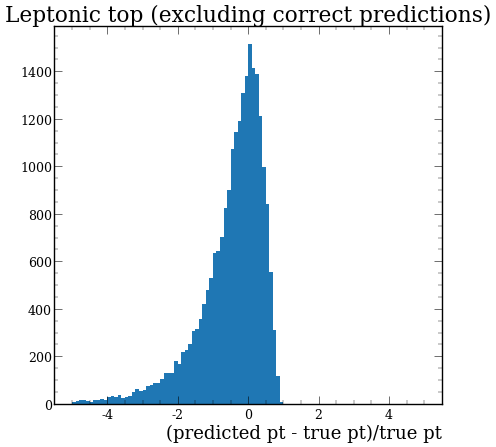

In [59]:
difference = leptop_true_pt - leptop_pred_pt
# Exclude correct predictions, i.e. zero differences
#difference = difference[difference != 0.]

rms_difference = np.sqrt(np.sum(difference**2)/len(difference))

plt.hist(difference/leptop_true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Leptonic top")
plt.show()

print(f"rms: {rms_difference:.3f}")

true_pt = leptop_true_pt[difference != 0.]
difference = difference[difference != 0.]

print(f"Average pt difference: {np.mean(difference):.3f}")
print(f"Median pt difference: {np.median(difference):.3f}")
print(f"Maximum pt difference: {np.max(difference):.3f}")
print(f"Minimum pt difference: {np.min(difference)}")

plt.hist(difference/true_pt, bins=100, range=(-5,5))
plt.xlabel("(predicted pt - true pt)/true pt")
plt.title("Leptonic top (excluding correct predictions)")
plt.show()

## Difference in jet $\Delta$R

Average delta R: 1.904
Median delta R: 1.875
Maximum delta R: 5.185
Minimum delta R: 0.401


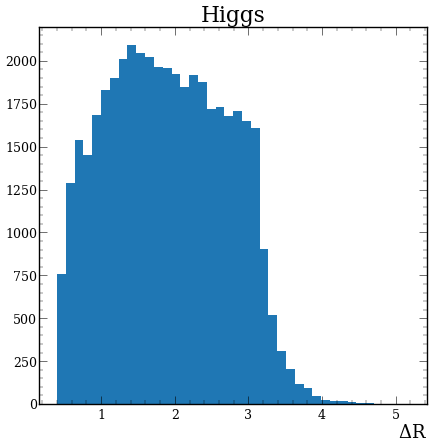

In [60]:
deltar = ak.flatten(higgs_jet_true.deltaR(higgs_jet_pred))
# delete correctly predicted
deltar = deltar[deltar != 0.]

print(f"Average delta R: {np.mean(deltar):.3f}")
print(f"Median delta R: {np.median(deltar):.3f}")
print(f"Maximum delta R: {np.max(deltar):.3f}")
print(f"Minimum delta R: {np.min(deltar):.3f}")

plt.hist(deltar, bins=40)
plt.xlabel(r"$\Delta R$")
plt.title("Higgs")
plt.show()

Average delta R: 1.839
Median delta R: 1.778
Maximum delta R: 4.916
Minimum delta R: 0.391


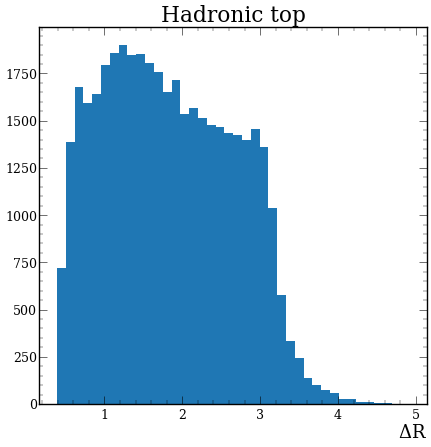

In [61]:
deltar = ak.flatten(hadtop_jet_true.deltaR(hadtop_jet_pred))
# delete correctly predicted
deltar = deltar[deltar != 0.]

print(f"Average delta R: {np.mean(deltar):.3f}")
print(f"Median delta R: {np.median(deltar):.3f}")
print(f"Maximum delta R: {np.max(deltar):.3f}")
print(f"Minimum delta R: {np.min(deltar):.3f}")

plt.hist(deltar, bins=40)
plt.xlabel(r"$\Delta R$")
plt.title("Hadronic top")
plt.show()

Average delta R: 1.976
Median delta R: 1.986
Maximum delta R: 4.888
Minimum delta R: 0.395


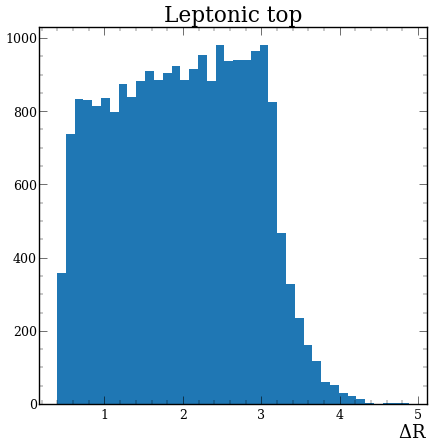

In [62]:
deltar = ak.flatten(leptop_jet_true.deltaR(leptop_jet_pred))
# delete correctly predicted
deltar = deltar[deltar != 0.]

print(f"Average delta R: {np.mean(deltar):.3f}")
print(f"Median delta R: {np.median(deltar):.3f}")
print(f"Maximum delta R: {np.max(deltar):.3f}")
print(f"Minimum delta R: {np.min(deltar):.3f}")

plt.hist(deltar, bins=40)
plt.xlabel(r"$\Delta R$")
plt.title("Leptonic top")
plt.show()

## Partons and jets $\Delta$R

In [ ]:
# Plot distance between target parton and predicted jet

In [9]:
df_jets = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v2.parquet")
jets, partons = ak.unzip(df_jets)

jets = ak.with_name(jets, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")

mask_fullymatched = ak.sum(jets.matched == True, axis=1)>=6

jets = jets[mask_fullymatched]
partons = partons[mask_fullymatched]

# Get fully matched jets from df_jets
mask_fullymatched = ak.sum(jets.matched == True, axis=1)>=6
jets = jets[mask_fullymatched]
higgs = jets[jets.prov == 1]
mask_match = ak.num(higgs) == 2

w_or_t_jets = jets[(jets.prov == 5)|(jets.prov == 2)]
mask_match = mask_match & (ak.num(w_or_t_jets) == 3)

lep_top = jets[jets.prov == 3]
mask_match = mask_match & (ak.num(lep_top) == 1)

jets = jets[mask_match]
partons = partons[mask_match]

Average delta R: 0.067
Median delta R: nan
Maximum delta R: 0.300
Minimum delta R: 0.000


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


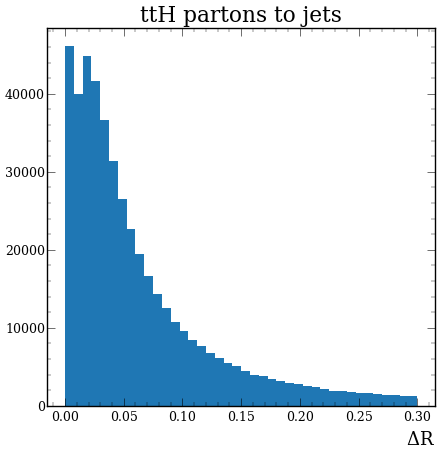

In [10]:
deltar = ak.flatten(partons.deltaR(jets))

print(f"Average delta R: {np.mean(deltar):.3f}")
print(f"Median delta R: {np.median(deltar):.3f}")
print(f"Maximum delta R: {np.max(deltar):.3f}")
print(f"Minimum delta R: {np.min(deltar):.3f}")

plt.hist(deltar, bins=40)
plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("ttH partons to jets", pad=10)
plt.show()

### Leptonic top

In [11]:
# Leptonic top jets
t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))

leptop_index_pred = t2_b_pred
leptop_index_true = t2_b_true

# ~~~~~ jets ~~~~~~~
leptop_jet_pred = jets[leptop_index_pred]
leptop_jet_true = jets[leptop_index_true]

mask = (leptop_jet_true == leptop_jet_pred)
leptop_jet_pred_correct = leptop_jet_pred[mask] # correctly predicted jets
leptop_jet_pred_wrong = leptop_jet_pred[~mask] # wrongly predicted jets

# Drop empty arrays
leptop_jet_pred_correct = leptop_jet_pred_correct[ak.num(leptop_jet_pred_correct)>0]
leptop_jet_pred_wrong = leptop_jet_pred_wrong[ak.num(leptop_jet_pred_wrong)>0]

# ~~~~~ partons ~~~~~~~
leptop_parton_pred = partons[leptop_index_pred]
leptop_parton_true = partons[leptop_index_true]

leptop_parton_pred_correct = leptop_parton_pred[mask]
leptop_parton_pred_wrong = leptop_parton_pred[~mask]

leptop_parton_pred_correct = leptop_parton_pred_correct[ak.num(leptop_parton_pred_correct)>0]
leptop_parton_pred_wrong = leptop_parton_pred_wrong[ak.num(leptop_parton_pred_wrong)>0]

Average delta R: 0.713
Median delta R: 0.080
Maximum delta R: 5.029
Minimum delta R: 0.00025


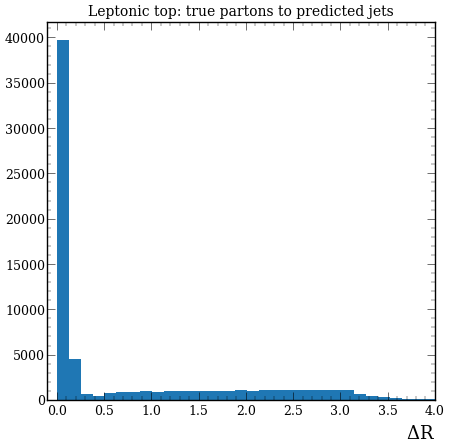

In [245]:
deltar = ak.flatten(leptop_parton_true.deltaR(leptop_jet_pred))

print(f"Average delta R: {np.mean(deltar):.3f}")
print(f"Median delta R: {np.median(deltar):.3f}")
print(f"Maximum delta R: {np.max(deltar):.3f}")
print(f"Minimum delta R: {np.min(deltar):.5f}")

plt.hist(deltar, bins=40)
plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Leptonic top: true partons to predicted jets", fontsize=20, pad=10)
plt.xlim(-0.1,4)
plt.show()

Average delta R: 0.067
Median delta R: 0.047
Maximum delta R: 0.300
Minimum delta R: 0.00021


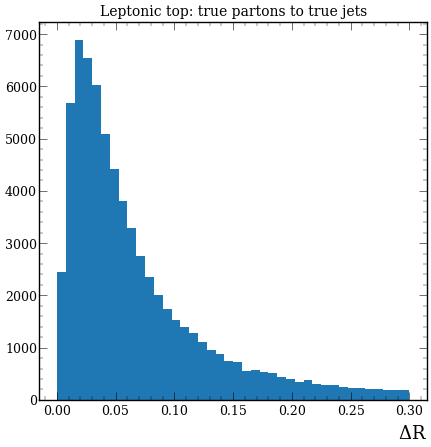

In [246]:
deltar = ak.flatten(leptop_parton_true.deltaR(leptop_jet_true))

print(f"Average delta R: {np.mean(deltar):.3f}")
print(f"Median delta R: {np.median(deltar):.3f}")
print(f"Maximum delta R: {np.max(deltar):.3f}")
print(f"Minimum delta R: {np.min(deltar):.5f}")

plt.hist(deltar, bins=40)
plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Leptonic top: true partons to true jets", fontsize=20, pad=10)
plt.show()

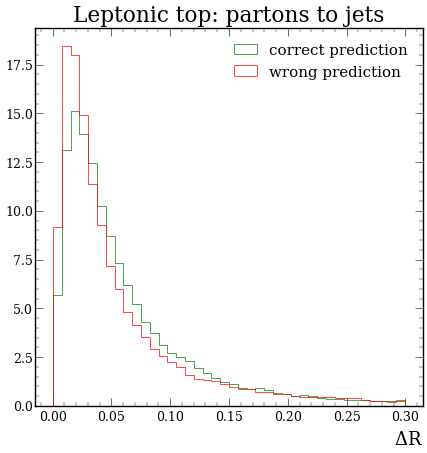

In [250]:
# Correct partons to correct jets
deltar = ak.flatten(leptop_parton_pred_correct.deltaR(leptop_jet_pred_correct))
plt.hist(deltar, bins=40, density=True, histtype="step", color='g',
         label="correct prediction")

# Wrong partons to wrong jets
deltar = ak.flatten(leptop_parton_pred_wrong.deltaR(leptop_jet_pred_wrong))
plt.hist(deltar, bins=40, density=True, histtype="step", color='r',
         label="wrong prediction")

plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Leptonic top: partons to jets", pad=10)
plt.legend()
plt.show()

### Higgs

In [98]:
# Higgs jets
H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
higgs_jet_true = jets[higgs_index_true]

H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])

H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))

higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)
higgs_jet_pred = jets[higgs_index_pred]

# ~~~~~ jets ~~~~~~~
higgs_jet_pred = jets[higgs_index_pred]
higgs_jet_true = jets[higgs_index_true]

mask = (higgs_jet_true == higgs_jet_pred)
higgs_jet_pred_correct = higgs_jet_pred[mask] 
higgs_jet_pred_wrong = higgs_jet_pred[~mask]

higgs_jet_pred_correct = higgs_jet_pred_correct[ak.num(higgs_jet_pred_correct)==2]
higgs_jet_pred_wrong = higgs_jet_pred_wrong[ak.num(higgs_jet_pred_wrong)>0]

# ~~~~~ partons ~~~~~~~
higgs_parton_pred = partons[higgs_index_pred]
higgs_parton_true = partons[higgs_index_true]

higgs_parton_pred_correct = higgs_parton_pred[mask] 
higgs_parton_pred_wrong = higgs_parton_pred[~mask]

higgs_parton_pred_correct = higgs_parton_pred_correct[ak.num(higgs_parton_pred_correct)==2]
higgs_parton_pred_wrong = higgs_parton_pred_wrong[ak.num(higgs_parton_pred_wrong)>0]

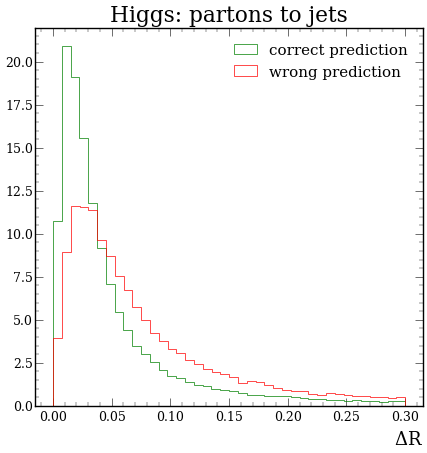

In [253]:
# Correct partons to correct jets
deltar = ak.flatten(higgs_parton_pred_correct.deltaR(higgs_jet_pred_correct))
plt.hist(deltar, bins=40, density=True, histtype="step", color='g',
         label="correct prediction")

# Wrong partons to wrong jets
deltar = ak.flatten(higgs_parton_pred_wrong.deltaR(higgs_jet_pred_wrong))
plt.hist(deltar, bins=40, density=True, histtype="step", color='r',
         label="wrong prediction")

plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Higgs: partons to jets", pad=10)
plt.legend()
plt.show()

In [99]:
higgs_jet_pred_correct = higgs_jet_pred_correct[ak.num(higgs_jet_pred_correct)==2]
higgs_jet_pred_wrong = higgs_jet_pred_wrong[ak.num(higgs_jet_pred_wrong)>0]

higgs_jet_pred_wrong_2 = higgs_jet_pred_wrong[ak.num(higgs_jet_pred_wrong)==2]
higgs_jet_pred_wrong_1 = higgs_jet_pred_wrong[ak.num(higgs_jet_pred_wrong)==1]

higgs_parton_pred_correct = higgs_parton_pred_correct[ak.num(higgs_parton_pred_correct)==2]
higgs_parton_pred_wrong = higgs_parton_pred_wrong[ak.num(higgs_parton_pred_wrong)>0]

higgs_parton_pred_wrong_2 = higgs_parton_pred_wrong[ak.num(higgs_parton_pred_wrong)==2]
higgs_parton_pred_wrong_1 = higgs_parton_pred_wrong[ak.num(higgs_parton_pred_wrong)==1]

higgs_parton_true_correct = higgs_parton_true[mask] 
higgs_parton_true_wrong = higgs_parton_true[~mask]

higgs_parton_true_correct = higgs_parton_true_correct[ak.num(higgs_parton_true_correct)==2]
higgs_parton_true_wrong = higgs_parton_true_wrong[ak.num(higgs_parton_true_wrong)>0]

higgs_parton_true_wrong_2 = higgs_parton_true_wrong[ak.num(higgs_parton_true_wrong)==2]
higgs_parton_true_wrong_1 = higgs_parton_true_wrong[ak.num(higgs_parton_true_wrong)==1]

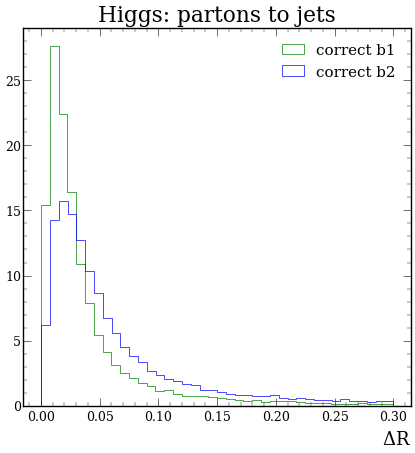

In [101]:
# Correct b1 to correct jets
deltar = higgs_parton_true_correct[:,0].deltaR(higgs_jet_pred_correct[:,0])
plt.hist(deltar, bins=40, density=True, histtype="step", color='g',
         label="correct b1")

# Correct b2 to correct jets
deltar = higgs_parton_true_correct[:,1].deltaR(higgs_jet_pred_correct[:,1])
plt.hist(deltar, bins=40, density=True, histtype="step", color='b',
         label="correct b2")

plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Higgs: partons to jets", pad=10)
plt.legend()
plt.show()

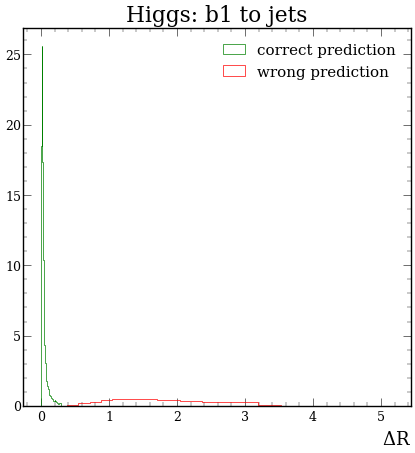

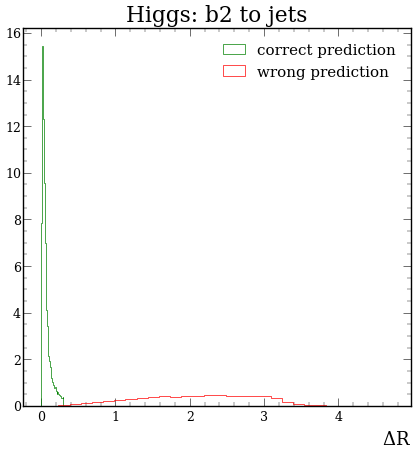

In [105]:
# Correct b1 to correct jets
deltar = higgs_parton_true_correct[:,0].deltaR(higgs_jet_pred_correct[:,0])
plt.hist(deltar, bins=30, density=True, histtype="step", color='g',
         label="correct prediction")

# Wrong b1 to wrong jets
deltar = higgs_parton_true_wrong_2[:,0].deltaR(higgs_jet_pred_wrong_2[:,0])
plt.hist(deltar, bins=30, density=True, histtype="step", color='r',
         label="wrong prediction")

plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Higgs: b1 to jets", pad=10)
plt.legend()
plt.show()

# Correct b2 to correct jets
deltar = higgs_parton_true_correct[:,1].deltaR(higgs_jet_pred_correct[:,1])
plt.hist(deltar, bins=30, density=True, histtype="step", color='g',
         label="correct prediction")

# Wrong b2 to wrong jets
deltar = higgs_parton_true_wrong_2[:,1].deltaR(higgs_jet_pred_wrong_2[:,1])
plt.hist(deltar, bins=30, density=True, histtype="step", color='r',
         label="wrong prediction")

plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Higgs: b2 to jets", pad=10)
plt.legend()
plt.show()

In [107]:
higgs_parton_true_wrong_2[0:10].prov.tolist()

[[1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0],
 [1.0, 1.0]]

In [103]:
higgs_jet_pred_wrong_2[0:10].prov.tolist()

[[1.0, 3.0],
 [2.0, 3.0],
 [5.0, 2.0],
 [3.0, 1.0],
 [4.0, 3.0],
 [1.0, 3.0],
 [1.0, 2.0],
 [1.0, 2.0],
 [4.0, 1.0],
 [1.0, 3.0]]

### Hadronic top

In [108]:
# Hadronic top jets
t1_q1_pred = ak.Array(df["TARGETS"]["t1"]["q1"][()])
t1_q2_pred = ak.Array(df["TARGETS"]["t1"]["q2"][()])
t1_b_pred = ak.Array(df["TARGETS"]["t1"]["b"][()])

t1_q1_pred = ak.unflatten(t1_q1_pred, ak.ones_like(t1_q1_pred))
t1_q2_pred = ak.unflatten(t1_q2_pred, ak.ones_like(t1_q2_pred))
t1_b_pred = ak.unflatten(t1_b_pred, ak.ones_like(t1_b_pred))

t1_q1_true = ak.Array(df_input["TARGETS"]["t1"]["q1"][()])
t1_q2_true = ak.Array(df_input["TARGETS"]["t1"]["q2"][()])
t1_b_true = ak.Array(df_input["TARGETS"]["t1"]["b"][()])

t1_q1_true = ak.unflatten(t1_q1_true, ak.ones_like(t1_q1_true))
t1_q2_true = ak.unflatten(t1_q2_true, ak.ones_like(t1_q2_true))
t1_b_true = ak.unflatten(t1_b_true, ak.ones_like(t1_b_true))

hadtop_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
hadtop_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)

# ~~~~~ jets ~~~~~~~
hadtop_jet_true = jets[hadtop_index_true]
hadtop_jet_pred = jets[hadtop_index_pred]

mask = (hadtop_jet_true == hadtop_jet_pred)
hadtop_jet_pred_correct = hadtop_jet_pred[mask] 
hadtop_jet_pred_wrong = hadtop_jet_pred[~mask]

hadtop_jet_pred_correct = hadtop_jet_pred_correct[ak.num(hadtop_jet_pred_correct)==3]
hadtop_jet_pred_wrong = hadtop_jet_pred_wrong[ak.num(hadtop_jet_pred_wrong)>0]

# ~~~~~ partons ~~~~~~~
hadtop_parton_pred = partons[hadtop_index_pred]
hadtop_parton_true = partons[hadtop_index_true]

hadtop_parton_pred_correct = hadtop_parton_pred[mask] 
hadtop_parton_pred_wrong = hadtop_parton_pred[~mask]

hadtop_parton_pred_correct = hadtop_parton_pred_correct[ak.num(hadtop_parton_pred_correct)==3]
hadtop_parton_pred_wrong = hadtop_parton_pred_wrong[ak.num(hadtop_parton_pred_wrong)>0]


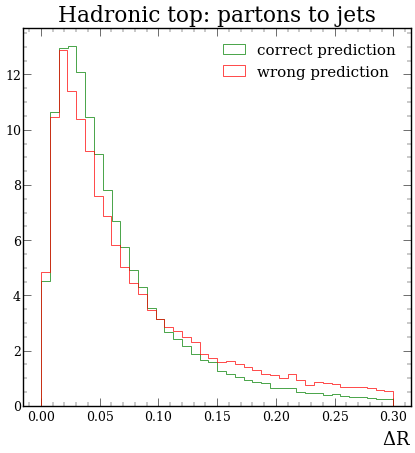

In [263]:
# Correct partons to correct jets
deltar = ak.flatten(hadtop_parton_pred_correct.deltaR(hadtop_jet_pred_correct))
plt.hist(deltar, bins=40, density=True, histtype="step", color='g',
         label="correct prediction")

# Wrong partons to wrong jets
deltar = ak.flatten(hadtop_parton_pred_wrong.deltaR(hadtop_jet_pred_wrong))
plt.hist(deltar, bins=40, density=True, histtype="step", color='r',
         label="wrong prediction")

plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Hadronic top: partons to jets", pad=10)
plt.legend()
plt.show()

In [109]:
hadtop_jet_pred_correct = hadtop_jet_pred_correct[ak.num(hadtop_jet_pred_correct)==3]
hadtop_jet_pred_wrong = hadtop_jet_pred_wrong[ak.num(hadtop_jet_pred_wrong)>0]

hadtop_jet_pred_wrong_3 = hadtop_jet_pred_wrong[ak.num(hadtop_jet_pred_wrong)==3]
hadtop_jet_pred_wrong_2 = hadtop_jet_pred_wrong[ak.num(hadtop_jet_pred_wrong)==2]
hadtop_jet_pred_wrong_1 = hadtop_jet_pred_wrong[ak.num(hadtop_jet_pred_wrong)==1]

hadtop_parton_pred_correct = hadtop_parton_pred_correct[ak.num(hadtop_parton_pred_correct)==3]
hadtop_parton_pred_wrong = hadtop_parton_pred_wrong[ak.num(hadtop_parton_pred_wrong)>0]

hadtop_parton_pred_wrong_3 = hadtop_parton_pred_wrong[ak.num(hadtop_parton_pred_wrong)==3]
hadtop_parton_pred_wrong_2 = hadtop_parton_pred_wrong[ak.num(hadtop_parton_pred_wrong)==2]
hadtop_parton_pred_wrong_1 = hadtop_parton_pred_wrong[ak.num(hadtop_parton_pred_wrong)==1]

hadtop_parton_true_correct = hadtop_parton_true[mask] 
hadtop_parton_true_wrong = hadtop_parton_true[~mask]

hadtop_parton_true_correct = hadtop_parton_true_correct[ak.num(hadtop_parton_true_correct)==3]
hadtop_parton_true_wrong = hadtop_parton_true_wrong[ak.num(hadtop_parton_true_wrong)>0]

hadtop_parton_true_wrong_3 = hadtop_parton_true_wrong[ak.num(hadtop_parton_true_wrong)==3]
hadtop_parton_true_wrong_2 = hadtop_parton_true_wrong[ak.num(hadtop_parton_true_wrong)==2]
hadtop_parton_true_wrong_1 = hadtop_parton_true_wrong[ak.num(hadtop_parton_true_wrong)==1]

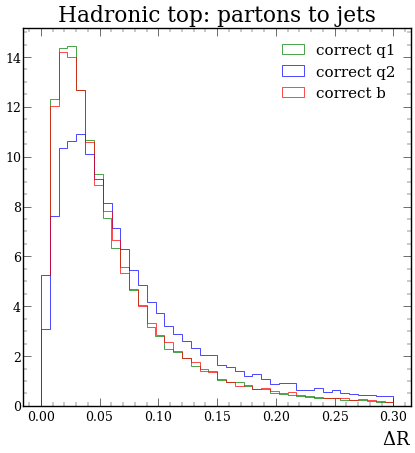

In [111]:
# Correct q1 to correct jets
deltar = hadtop_parton_true_correct[:,0].deltaR(hadtop_jet_pred_correct[:,0])
plt.hist(deltar, bins=40, density=True, histtype="step", color='g',
         label="correct q1")

# Correct q2 to correct jets
deltar = hadtop_parton_true_correct[:,1].deltaR(hadtop_jet_pred_correct[:,1])
plt.hist(deltar, bins=40, density=True, histtype="step", color='b',
         label="correct q2")

# Correct b to correct jets
deltar = hadtop_parton_true_correct[:,2].deltaR(hadtop_jet_pred_correct[:,2])
plt.hist(deltar, bins=40, density=True, histtype="step", color='r',
         label="correct b")

plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Hadronic top: partons to jets", pad=10)
plt.legend()
plt.show()

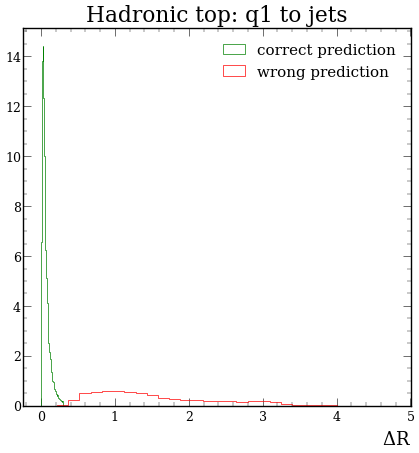

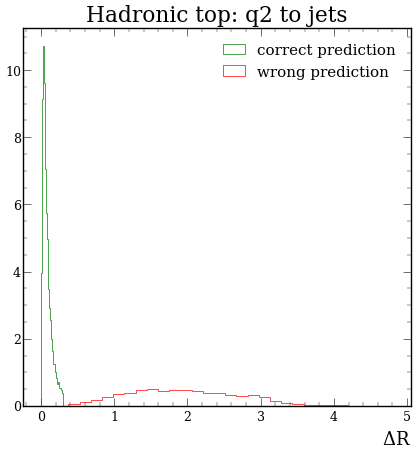

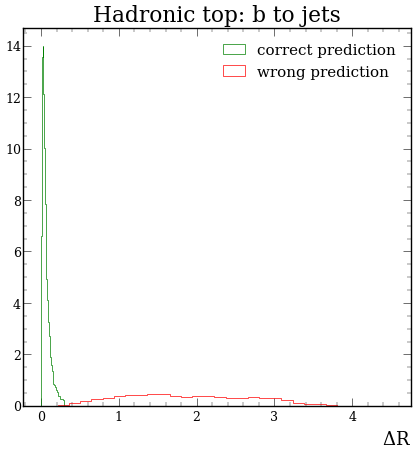

In [112]:
# Correct q1 to correct jets
deltar = hadtop_parton_true_correct[:,0].deltaR(hadtop_jet_pred_correct[:,0])
plt.hist(deltar, bins=30, density=True, histtype="step", color='g',
         label="correct prediction")

# Wrong q1 to wrong jets
deltar = hadtop_parton_true_wrong_3[:,0].deltaR(hadtop_jet_pred_wrong_3[:,0])
plt.hist(deltar, bins=30, density=True, histtype="step", color='r',
         label="wrong prediction")

plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Hadronic top: q1 to jets", pad=10)
plt.legend()
plt.show()

# Correct q2 to correct jets
deltar = hadtop_parton_true_correct[:,1].deltaR(hadtop_jet_pred_correct[:,1])
plt.hist(deltar, bins=30, density=True, histtype="step", color='g',
         label="correct prediction")

# Wrong q2 to wrong jets
deltar = hadtop_parton_true_wrong_3[:,1].deltaR(hadtop_jet_pred_wrong_3[:,1])
plt.hist(deltar, bins=30, density=True, histtype="step", color='r',
         label="wrong prediction")

plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Hadronic top: q2 to jets", pad=10)
plt.legend()
plt.show()

# Correct b to correct jets
deltar = hadtop_parton_true_correct[:,2].deltaR(hadtop_jet_pred_correct[:,2])
plt.hist(deltar, bins=30, density=True, histtype="step", color='g',
         label="correct prediction")

# Wrong b to wrong jets
deltar = hadtop_parton_true_wrong_3[:,2].deltaR(hadtop_jet_pred_wrong_3[:,2])
plt.hist(deltar, bins=30, density=True, histtype="step", color='r',
         label="wrong prediction")

plt.xlabel(r"$\Delta R$", labelpad=10)
plt.title("Hadronic top: b to jets", pad=10)
plt.legend()
plt.show()

In [118]:
hadtop_parton_true_wrong_3[0:10].prov.tolist()

[[5.0, 5.0, 2.0],
 [5.0, 5.0, 2.0],
 [5.0, 5.0, 2.0],
 [5.0, 5.0, 2.0],
 [5.0, 5.0, 2.0],
 [5.0, 5.0, 2.0],
 [5.0, 5.0, 2.0],
 [5.0, 5.0, 2.0],
 [5.0, 5.0, 2.0],
 [5.0, 5.0, 2.0]]

In [117]:
hadtop_jet_pred_wrong_3[0:10].prov.tolist()

[[2.0, 5.0, 5.0],
 [5.0, 3.0, 1.0],
 [-1.0, 1.0, 1.0],
 [1.0, 3.0, 1.0],
 [5.0, 2.0, 5.0],
 [1.0, 5.0, 1.0],
 [4.0, 5.0, 3.0],
 [1.0, 5.0, 1.0],
 [1.0, 5.0, 1.0],
 [1.0, -1.0, 1.0]]